In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

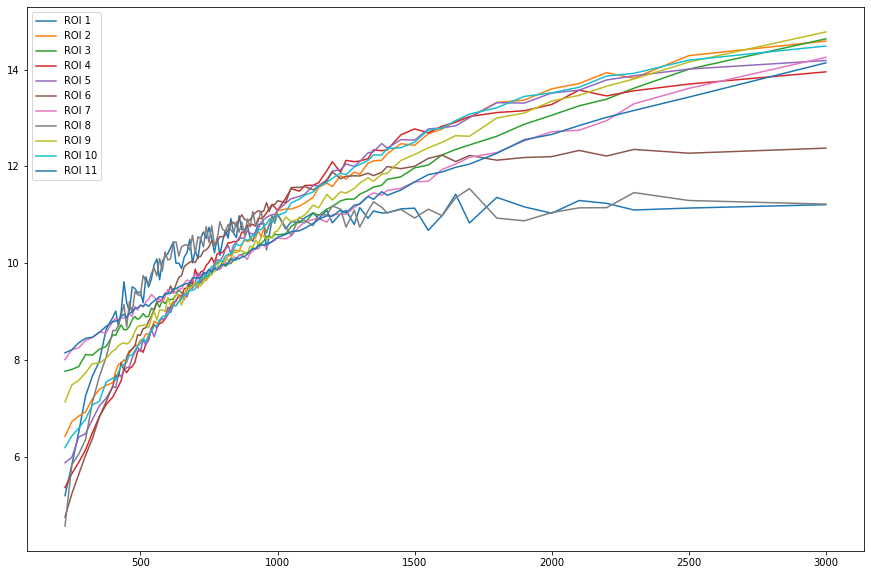

In [110]:
ti_seq = np.array([*list(range(50, 400, 25)),
                       *list(range(400, 1000, 10)),
                       1000, 1030, 1050, 1080, 1100, 1130, 1150, 1180, 1200, 1230, 1250, 1280, 1300, 1330, 1350, 1380,
                       1400, 1450, 1500, 1550, 1600, 1650, 1700,
                       1800, 1900, 2000, 2100, 2200, 2300, 2500, 3000], dtype=float)

file_name = "1111111111_15s_ep2d_se_til_shlomi_50-3000_2m2ISO_cor_PAT2_TE22_TR30k.nii.gz.txt"
roi = pd.read_csv(file_name, sep='\t', header=1).dropna(axis=1)
low = 7

plt.figure(figsize=(15,10))
for r in roi['ROI'].unique():
    roir = roi.where(roi['ROI'] == r).dropna()['Mean'].values[low:]
    roir *= 1000. / np.sum(roir)
    plt.plot(ti_seq[low:],roir,label=r)

plt.legend()
plt.show()

In [111]:
def M(ti, *params):
    # params[2 * j]     = MO_j
    # params[2 * j + 1] = T1_j
    ncurv = len(params) // 2
    out = 0.

    # M = \sum_j M0_j (1 - 2 e^{-TI/T1j})
    for j in range(ncurv):
        out += params[2 * j] * (1. - 2. * np.exp(-ti  / params[2 * j + 1]))

    return out

def jacM(t, *params):
    ncurv = len(params) // 2
    out = [0] * (ncurv * 2)

    for j in range(ncurv):
        # \partial M(t,...)/\partial M_i = 1 - 2 e^{-t/T_j}
        out[2 * j] = 1. - 2. * np.exp(-t / params[2 * j + 1])

        # \partial M(t,...)/\partial T_i = M_i (-2) e^{-t/T_i} (-t) (-1)/ T_i^2
        out[2 * j + 1] = - params[2 * j] * 2. * np.exp(-t / params[2 * j + 1]) * t / (
                    params[2 * j + 1] * params[2 * j + 1])

    return np.transpose(out)

def flip(values):
    flipped = np.copy(values)
    min_index = np.argmin(values)
    for i in range(0, min_index):
        flipped[i] = 2 * values[min_index] - values[i]
    return flipped


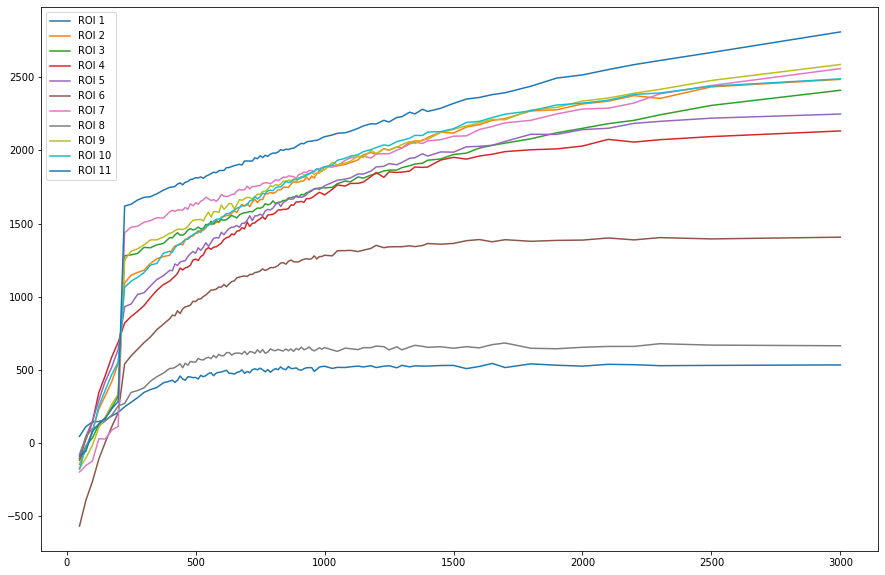

In [112]:
plt.figure(figsize=(15,10))
rois_sig = []
for r in roi['ROI'].unique():
    roir = roi.where(roi['ROI'] == r).dropna()['Mean'].values[:]
    plt.plot(ti_seq, flip(roir),label=r)
    rois_sig.append(roir)
plt.legend()
plt.show()

In [123]:
# curve fit sa nechyta na datach bez zaciatku, chyba mu nabeh

plt.figure(figsize=(15,15))
for i, roi in enumerate(rois_sig):
    par, cov = curve_fit(M,
                     ti_seq,
                     flip(roi),
                     p0=[50, 15])

    fitted = [M(t, *par) for t in ti_seq]
    plt.subplot(4, 3, i + 1)
    plt.plot(ti_seq, roi, label='roi')
    plt.plot(ti_seq, flip(roi), label='flip')
    plt.plot(ti_seq, fitted, label='fit')
    plt.title("roi-{}: {}".format(i, par.round()))
    plt.legend()
plt.show()

In [124]:
plt.figure(figsize=(15,15))
for i, roi in enumerate(rois_sig):
    min_idx = np.argmin(roi)
    par, cov = curve_fit(M,
                     ti_seq[min_idx : ],
                     flip(roi[min_idx : ]),
                     p0=[1500, 800, 0],
                     bounds=(0, 3000))

    fitted = [M(t, *par) for t in ti_seq[min_idx : ]]
    plt.subplot(4, 3, i + 1)
    plt.plot(ti_seq[min_idx :], flip(roi[min_idx : ]), label='roi')
    plt.plot(ti_seq[min_idx :], fitted, label='fit')
    plt.xlim(0, 3000)
    plt.legend()
    plt.title("roi-{}: {}".format(i, par.round()))
plt.show()


In [125]:
def fit_shift(ti, *params):
    # params[0] = M0
    # params[1] = T1
    # params[2] = C cons
    return  params[0] * (1. - 2. * np.exp((-ti - params[2]) / params[1]))

plt.figure(figsize=(15,15))
for i, roi in enumerate(rois_sig):
    min_idx = np.argmin(roi)
    par, cov = curve_fit(fit_shift,
                     ti_seq[min_idx : ],
                     flip(roi[min_idx : ]),
                     p0=[1500, 800, 0],
                     bounds=(0, 3000))

    fitted = [fit_shift(t, *par) for t in ti_seq[min_idx : ]]
    plt.subplot(4, 3, i + 1)
    plt.plot(ti_seq[min_idx :], flip(roi[min_idx : ]), label='roi')
    plt.plot(ti_seq[min_idx :], fitted, label='fit')
    plt.xlim(0, 3000)
    plt.legend()
    plt.title("roi-{}: {}".format(i, par.round()))
plt.show()

In [129]:
def fit_lubos_1(ti, *params):
    # params[0] = M0
    # params[1] = T1
    # params[2] = TR
    return params[0] * (1. - 2. * np.exp(-ti / params[1]) + np.exp(params[2] / params[1])) + params[3]


plt.figure(figsize=(15,15))
for i, roi in enumerate(rois_sig):
    min_idx = np.argmin(roi)
    par, cov = curve_fit(fit_lubos_1,
                     ti_seq[min_idx : ],
                     roi[min_idx : ],
                     p0=[1500, 800, 0, 0],
                     bounds=(0, 3000))

    fitted = [fit_lubos_1(t, *par) for t in ti_seq[min_idx : ]]
    plt.subplot(4, 3, i + 1)
    plt.plot(ti_seq[min_idx :], roi[min_idx : ], label='roi')
    plt.plot(ti_seq[min_idx :], fitted, label='fit')
    plt.xlim(0, 3000)
    plt.legend()
    plt.title("roi-{}: {}".format(i, par.round()))
plt.show()

In [128]:
def fit_lubos_2(ti, *params):
    # params[0] = M0
    # params[1] = T1
    # M0 * (1. - 2*np.exp(-TI / T1)+ np.exp(-(30000-TI)/T1))
    return params[0] * (1. - 2. * np.exp(-ti / params[1]) + np.exp(-(30000 - ti) / params[1]))


plt.figure(figsize=(15,15))
for i, roi in enumerate(rois_sig):
    min_idx = np.argmin(roi)
    par, cov = curve_fit(fit_lubos_2,
                     ti_seq[min_idx : ],
                     roi[min_idx : ],
                     p0=[1500, 800, 0],
                     bounds=(0, 3000))

    fitted = [fit_lubos_2(t, *par) for t in ti_seq[min_idx : ]]
    plt.subplot(4, 3, i + 1)
    plt.plot(ti_seq[min_idx :], roi[min_idx : ] , label='roi')
    plt.plot(ti_seq[min_idx :], fitted, label='fit')
    plt.xlim(0, 3000)
    plt.legend()
    plt.title("roi-{}: {}".format(i, par.round()))
plt.show()